# Lstm

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
Accuracy: 0.9831
Precision: 0.9522
Recall: 0.9625
F1-score: 0.9573
ROC AUC: 0.9982
PR AUC: 0.9930


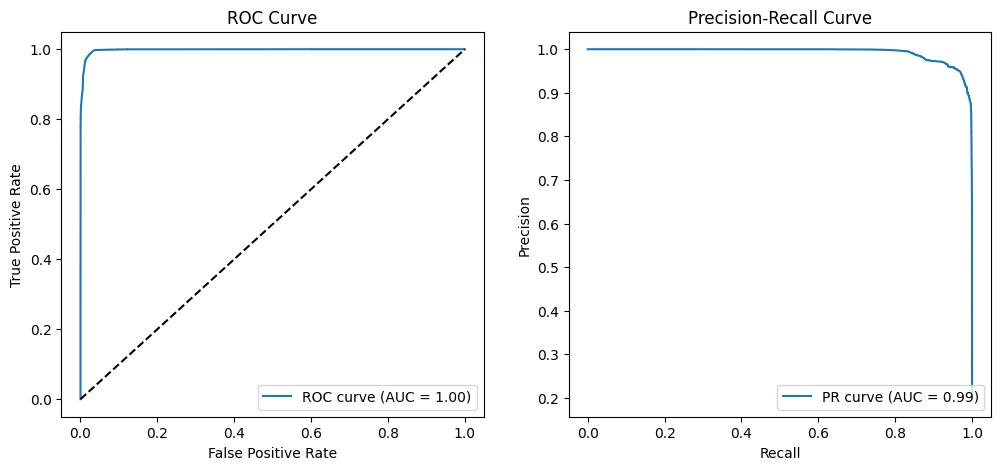

In [ ]:
import glob
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

# Config
NUM_CLIENTS = 5
NUM_EPOCHS = 5
BATCH_SIZE = 64
LR = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
csv_files = glob.glob('*.csv')

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)
full_df = pd.concat(dfs, ignore_index=True)

########## Step 2: Preprocess data ##########
# Drop columns with all missing values if any
full_df = full_df.dropna(axis=1)

# Encode Labels to binary (BENIGN = 0, attack = 1)
def encode_labels(df):
    le = LabelEncoder()
    df[' Label'] = le.fit_transform(df[' Label'])
    df[' Label'] = df[' Label'].apply(lambda x: 0 if le.classes_[x] == 'BENIGN' else 1)
    return df

full_df = encode_labels(full_df)

# Select only numeric features + Label
full_df = full_df.select_dtypes(include=[np.number])

########## Step 3: Separate features and labels ##########
X = full_df.drop(' Label', axis=1).values
y = full_df[' Label'].values
X[np.isinf(X)] = np.nan

# Drop rows with NaN (you can also choose to fill them with 0 or mean)
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]
########## Step 4: Standardize features ##########
scaler = StandardScaler()
X = scaler.fit_transform(X)

########## Step 5: Train-test split ##########
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

########## Step 6: Federated client data split ##########
clients_data = []
size = len(X_train) // NUM_CLIENTS
start = 0
for i in range(NUM_CLIENTS):
    end = start + size if i < NUM_CLIENTS - 1 else len(X_train)
    clients_data.append((X_train[start:end], y_train[start:end]))
    start = end

########## Step 7: PyTorch Dataset ##########
class IDS_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

########## Step 8: Model definition ##########
class LSTM_IDS(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, output_dim=2):
        super(LSTM_IDS, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)  # shape (batch_size, seq_len=1, input_dim)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

########## Step 9: Training & Evaluation Functions ##########
def train_local_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for _ in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(DEVICE)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_scores.extend(probs[:,1].cpu().numpy())  # Prob for positive class
    return np.array(y_true), np.array(y_pred), np.array(y_scores)

def aggregate_models(global_model, local_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        # Average weights from all local models
        global_dict[key] = torch.stack([local_models[i].state_dict()[key].float() for i in range(len(local_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)

########## Step 10: Federated Training ##########
input_dim = X_train.shape[1]
global_model = LSTM_IDS(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss()

for round in range(NUM_EPOCHS):
    local_models = []
    print(f"Round {round+1}/{NUM_EPOCHS}")
    for client_idx in range(NUM_CLIENTS):
        local_model = LSTM_IDS(input_dim).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())  # start from global weights
        optimizer = torch.optim.Adam(local_model.parameters(), lr=LR)

        train_x, train_y = clients_data[client_idx]
        train_dataset = IDS_Dataset(train_x, train_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        train_local_model(local_model, train_loader, criterion, optimizer, epochs=1)
        local_models.append(local_model)

    aggregate_models(global_model, local_models)

########## Step 11: Evaluate ##########
test_dataset = IDS_Dataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_true, y_pred, y_scores = evaluate_model(global_model, test_loader)

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

########## (Optional) Step 12: Plot ROC and PR curves ##########
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, y_scores)
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')

plt.show()


# cnn-lstm

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
Accuracy: 0.9839
Precision: 0.9477
Recall: 0.9716
F1-score: 0.9595
ROC AUC: 0.9985
PR AUC: 0.9940


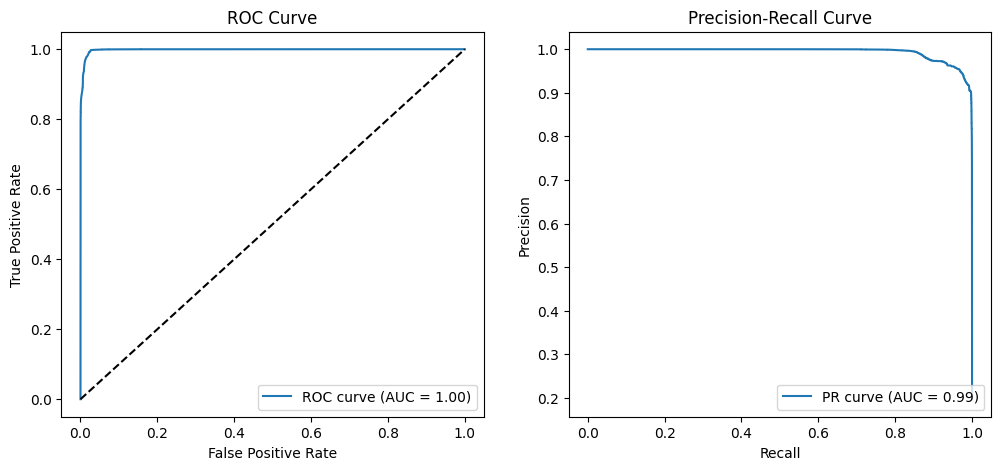

In [ ]:
import glob
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

# Config
NUM_CLIENTS = 5
NUM_EPOCHS = 5
BATCH_SIZE = 64
LR = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
csv_files = glob.glob('*.csv')

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)
full_df = pd.concat(dfs, ignore_index=True)

########## Step 2: Preprocess data ##########
# Drop columns with all missing values if any
full_df = full_df.dropna(axis=1)

# Encode Labels to binary (BENIGN = 0, attack = 1)
def encode_labels(df):
    le = LabelEncoder()
    df[' Label'] = le.fit_transform(df[' Label'])
    df[' Label'] = df[' Label'].apply(lambda x: 0 if le.classes_[x] == 'BENIGN' else 1)
    return df

full_df = encode_labels(full_df)

# Select only numeric features + Label
full_df = full_df.select_dtypes(include=[np.number])

########## Step 3: Separate features and labels ##########
X = full_df.drop(' Label', axis=1).values
y = full_df[' Label'].values
X[np.isinf(X)] = np.nan

# Drop rows with NaN
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

########## Step 4: Standardize features ##########
scaler = StandardScaler()
X = scaler.fit_transform(X)

########## Step 5: Train-test split ##########
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

########## Step 6: Federated client data split ##########
clients_data = []
size = len(X_train) // NUM_CLIENTS
start = 0
for i in range(NUM_CLIENTS):
    end = start + size if i < NUM_CLIENTS - 1 else len(X_train)
    clients_data.append((X_train[start:end], y_train[start:end]))
    start = end

########## Step 7: PyTorch Dataset ##########
class IDS_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

########## Step 8: CNN-LSTM Model definition ##########
class CNN_LSTM_IDS(nn.Module):
    def __init__(self, input_dim, cnn_channels=32, lstm_hidden_dim=64, lstm_layers=1, output_dim=2):
        super(CNN_LSTM_IDS, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, channels=1, seq_len=input_dim)
        x = self.cnn(x)     # (batch, cnn_channels, seq_len//2)
        x = x.permute(0, 2, 1)  # (batch, seq_len//2, cnn_channels)
        out, _ = self.lstm(x)   # (batch, seq_len//2, lstm_hidden_dim)
        out = out[:, -1, :]     # Take last time step
        out = self.fc(out)      # (batch, output_dim)
        return out

########## Step 9: Training & Evaluation Functions ##########
def train_local_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for _ in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(DEVICE)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_scores.extend(probs[:,1].cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_scores)

def aggregate_models(global_model, local_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([local_models[i].state_dict()[key].float() for i in range(len(local_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)

########## Step 10: Federated Training ##########
input_dim = X_train.shape[1]
global_model = CNN_LSTM_IDS(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss()

for round in range(NUM_EPOCHS):
    local_models = []
    print(f"Round {round+1}/{NUM_EPOCHS}")
    for client_idx in range(NUM_CLIENTS):
        local_model = CNN_LSTM_IDS(input_dim).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        optimizer = torch.optim.Adam(local_model.parameters(), lr=LR)

        train_x, train_y = clients_data[client_idx]
        train_dataset = IDS_Dataset(train_x, train_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        train_local_model(local_model, train_loader, criterion, optimizer, epochs=1)
        local_models.append(local_model)

    aggregate_models(global_model, local_models)

########## Step 11: Evaluate ##########
test_dataset = IDS_Dataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_true, y_pred, y_scores = evaluate_model(global_model, test_loader)

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

########## (Optional) Step 12: Plot ROC and PR curves ##########
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, y_scores)
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')

plt.show()


#scnn-lstm

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
Accuracy: 0.9851
Precision: 0.9516
Recall: 0.9739
F1-score: 0.9626
ROC AUC: 0.9987
PR AUC: 0.9946


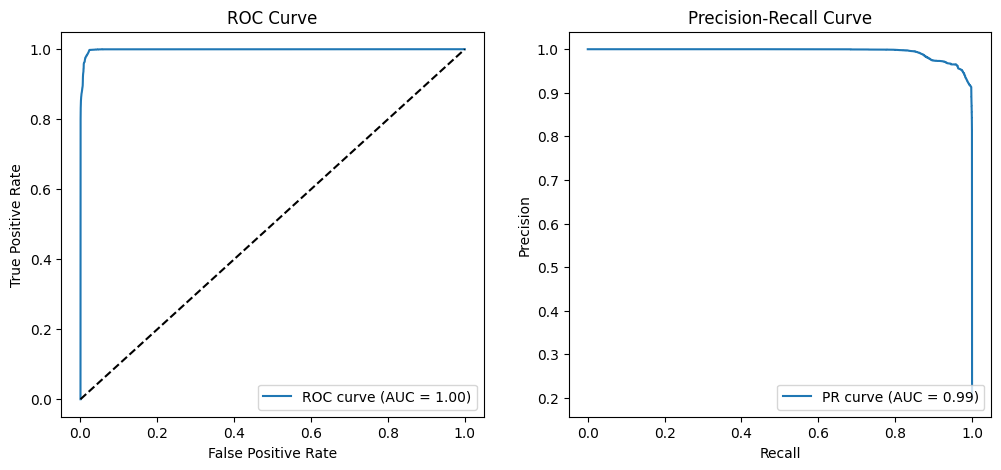

In [ ]:
import glob
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

# ========== CONFIGURATION ==========
NUM_CLIENTS = 5
NUM_EPOCHS = 5
BATCH_SIZE = 64
LR = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
csv_files = glob.glob('*.csv')

# ========== DATA LOADING ==========
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)
full_df = pd.concat(dfs, ignore_index=True)

# ========== PREPROCESSING ==========
full_df = full_df.dropna(axis=1)

def encode_labels(df):
    le = LabelEncoder()
    df[' Label'] = le.fit_transform(df[' Label'])
    df[' Label'] = df[' Label'].apply(lambda x: 0 if le.classes_[x] == 'BENIGN' else 1)
    return df

full_df = encode_labels(full_df)
full_df = full_df.select_dtypes(include=[np.number])

X = full_df.drop(' Label', axis=1).values
y = full_df[' Label'].values
X[np.isinf(X)] = np.nan
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

clients_data = []
size = len(X_train) // NUM_CLIENTS
start = 0
for i in range(NUM_CLIENTS):
    end = start + size if i < NUM_CLIENTS - 1 else len(X_train)
    clients_data.append((X_train[start:end], y_train[start:end]))
    start = end

class IDS_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ========== STACKED CNN-LSTM MODEL ==========
class StackedCNN_LSTM_IDS(nn.Module):
    def __init__(self, input_dim, cnn_channels1=32, cnn_channels2=64, lstm_hidden_dim=64, lstm_layers=2, output_dim=2):
        super(StackedCNN_LSTM_IDS, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, cnn_channels1, kernel_size=3, padding=1),  # First CNN
            nn.ReLU(),
            nn.Conv1d(cnn_channels1, cnn_channels2, kernel_size=3, padding=1),  # Second CNN (stacked)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)  # Optional pooling
        )
        self.lstm = nn.LSTM(
            input_size=cnn_channels2,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True
        )
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, channels=1, seq_len=input_dim)
        x = self.cnn(x)  # (batch, cnn_channels2, seq_len//2)
        x = x.permute(0, 2, 1)  # (batch, seq_len//2, cnn_channels2)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# ========== TRAINING/EVAL FUNCTIONS ==========
def train_local_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for _ in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(DEVICE)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_scores.extend(probs[:,1].cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_scores)

def aggregate_models(global_model, local_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([local_models[i].state_dict()[key].float() for i in range(len(local_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)

# ========== FEDERATED TRAINING ==========
input_dim = X_train.shape[1]
global_model = StackedCNN_LSTM_IDS(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss()

for round in range(NUM_EPOCHS):
    local_models = []
    print(f"Round {round+1}/{NUM_EPOCHS}")
    for client_idx in range(NUM_CLIENTS):
        local_model = StackedCNN_LSTM_IDS(input_dim).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        optimizer = torch.optim.Adam(local_model.parameters(), lr=LR)

        train_x, train_y = clients_data[client_idx]
        train_dataset = IDS_Dataset(train_x, train_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        train_local_model(local_model, train_loader, criterion, optimizer, epochs=1)
        local_models.append(local_model)
    aggregate_models(global_model, local_models)

# ========== EVALUATE ==========
test_dataset = IDS_Dataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_true, y_pred, y_scores = evaluate_model(global_model, test_loader)

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

from sklearn.metrics import roc_curve, precision_recall_curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')

plt.show()


#scnn-lstm non iid

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5
Accuracy: 0.9822
Precision: 0.9410
Recall: 0.9706
F1-score: 0.9556
ROC AUC: 0.9981
PR AUC: 0.9925


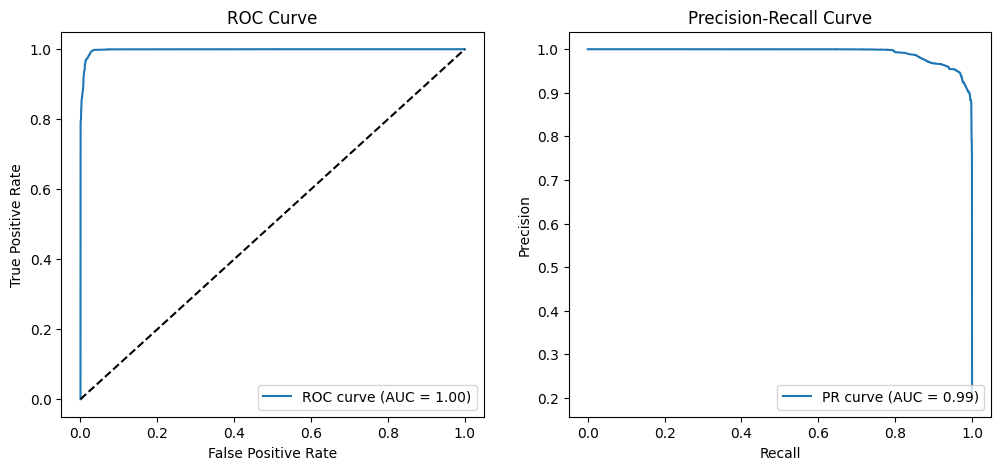

In [ ]:
import glob
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import random

# ========== CONFIGURATION ==========
NUM_CLIENTS = 5
NUM_EPOCHS = 5
BATCH_SIZE = 64
LR = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
csv_files = glob.glob('*.csv')

# ========== DATA LOADING ==========
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)
full_df = pd.concat(dfs, ignore_index=True)

# ========== PREPROCESSING ==========
full_df = full_df.dropna(axis=1)

def encode_labels(df):
    le = LabelEncoder()
    df[' Label'] = le.fit_transform(df[' Label'])
    df[' Label'] = df[' Label'].apply(lambda x: 0 if le.classes_[x] == 'BENIGN' else 1)
    return df

full_df = encode_labels(full_df)
full_df = full_df.select_dtypes(include=[np.number])

X = full_df.drop(' Label', axis=1).values
y = full_df[' Label'].values
X[np.isinf(X)] = np.nan
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# ========== NON-IID CLIENT PARTITION (Label-Skewed) ==========
def noniid_partition(X, y, num_clients=NUM_CLIENTS, seed=42):
    np.random.seed(seed)
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]

    np.random.shuffle(idx_0)
    np.random.shuffle(idx_1)

    size_0 = len(idx_0) // num_clients
    size_1 = len(idx_1) // num_clients

    clients_data = []

    for i in range(num_clients):
        if i % 2 == 0:
            main_idx = idx_0[size_0*i : size_0*(i+1)]
            # Take a small fixed fraction of other class for non-IID mix
            other_idx_end = min(len(idx_1), size_1*(i//3 + 1))
            other_idx = idx_1[size_1*i//3 : other_idx_end]
        else:
            main_idx = idx_1[size_1*i : size_1*(i+1)]
            other_idx_end = min(len(idx_0), size_0*(i//3 + 1))
            other_idx = idx_0[size_0*i//3 : other_idx_end]

        indices = np.concatenate((main_idx, other_idx))
        np.random.shuffle(indices)
        clients_data.append((X[indices], y[indices]))

    return clients_data


clients_data = noniid_partition(X_train, y_train, NUM_CLIENTS)

# ========== DATASET CLASS ==========
class IDS_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ========== STACKED CNN-LSTM MODEL ==========
class StackedCNN_LSTM_IDS(nn.Module):
    def __init__(self, input_dim, cnn_channels1=32, cnn_channels2=64, lstm_hidden_dim=64, lstm_layers=2, output_dim=2):
        super(StackedCNN_LSTM_IDS, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, cnn_channels1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(cnn_channels1, cnn_channels2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        self.lstm = nn.LSTM(
            input_size=cnn_channels2,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True
        )
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# ========== TRAINING/EVAL FUNCTIONS ==========
def train_local_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for _ in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(DEVICE)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_scores.extend(probs[:,1].cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_scores)

def aggregate_models(global_model, local_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([local_models[i].state_dict()[key].float() for i in range(len(local_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)

# ========== FEDERATED TRAINING ==========
input_dim = X_train.shape[1]
global_model = StackedCNN_LSTM_IDS(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss()

for round in range(NUM_EPOCHS):
    local_models = []
    print(f"Round {round+1}/{NUM_EPOCHS}")
    for client_idx in range(NUM_CLIENTS):
        local_model = StackedCNN_LSTM_IDS(input_dim).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        optimizer = torch.optim.Adam(local_model.parameters(), lr=LR)

        train_x, train_y = clients_data[client_idx]
        train_dataset = IDS_Dataset(train_x, train_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        train_local_model(local_model, train_loader, criterion, optimizer, epochs=1)
        local_models.append(local_model)
    aggregate_models(global_model, local_models)

# ========== EVALUATION ==========
test_dataset = IDS_Dataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_true, y_pred, y_scores = evaluate_model(global_model, test_loader)

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

from sklearn.metrics import roc_curve, precision_recall_curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')

plt.show()
